# Notebook Objective and Setup

BGG08 contains the Collaborative Filtering model.

Th CF is tested in both memory and model-based modes, on both the user's real ratings data and the synthesized data sets.

Using testing results, we select the most efficient recommendation system and make our business recommendations.

## Business Objective

Build a content recommender for BoardGameGeek with a goal of addressing challenges that are both common to recommenders in general, and specific to BGG:

- Cost of acquiring and maintaining data
- Cold Start problems where new users and items are not a part of the system
- Catalog coverage problems where popularity bias results in items of the catalog that are not in the recommendation system
- Sparse matrix issue where a combination of many items, many users, and few ratings results in low user/item crossover for identifying neighbors
- BGG specific problem where reimplementatons/reskins of games result in separated user profiles when they should be similar
- Computational cost/time limitations when issuing recommendations

## Package Imports

In [1]:
import pandas as pd
import numpy as np
import requests
import regex as re
import time
import os
import gc
import json
import copy
from statistics import mean
from statistics import median

# ignore warnings (gets rid of Pandas copy warnings)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from scipy import spatial

# scoring and algorithm selection packages
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from sklearn.inspection import permutation_importance

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

'''from surprise import KNNWithMeans, SVD, Dataset, Reader, dump, accuracy, NMF, BaselineOnly
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import KFold
from surprise.prediction_algorithms.matrix_factorization import SVD, SVDpp, NMF
from surprise.prediction_algorithms.slope_one import SlopeOne
from surprise.prediction_algorithms.co_clustering import CoClustering
from surprise.prediction_algorithms.random_pred import NormalPredictor
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.model_selection.search import GridSearchCV'''

'from surprise import KNNWithMeans, SVD, Dataset, Reader, dump, accuracy, NMF, BaselineOnly\nfrom surprise.model_selection.validation import cross_validate\nfrom surprise.model_selection import KFold\nfrom surprise.prediction_algorithms.matrix_factorization import SVD, SVDpp, NMF\nfrom surprise.prediction_algorithms.slope_one import SlopeOne\nfrom surprise.prediction_algorithms.co_clustering import CoClustering\nfrom surprise.prediction_algorithms.random_pred import NormalPredictor\nfrom surprise.prediction_algorithms.baseline_only import BaselineOnly\nfrom surprise.model_selection.search import GridSearchCV'

## Notebook Functions

In [2]:
def get_user_similarity(this_dictionary, user_a, all_users_ratings, user_items, v):
    '''
    Takes in a user and dictionary of other users and their game ratings. 
    Finds users_b who have an intersection of at least v rated items (both have rated the same v items). 
    Calculates the cosine distance between user_a and each qualifying user_b.
    Stores similarity to users_b in similarity_dictionary and returns similarity_dictionary.
    
    Inputs:
    this_dictionary: existing similarities dictionary in case a similarity already exists between users
    user_a: The user that we are finding neighbors for
    all_users_ratings: all users in the system
    user_items: the items that user_a has rated
    v: number of items the users must have in common to have their distance scored and recorded
    
    Outputs:
    similarity_dictionary: dictionary with similarity between user_a and each other users with a set match
    
    '''
    
    # start a list for the user distances
    similarity_dictionary = {}
    
    # for each user b in the dictionary:
    for user_b in all_users_ratings:
        
        if user_b == user_a:
            continue
        
        # toggle this OFF if NOT grid searching
        if user_b in this_dictionary[user_a]:
            # append the distance to the 
            similarity_dictionary[user_b] = this_dictionary[user_b][user_a]
            pass
        ## END OF STUFF TO TOGGLE
        
        else:
            
            
            # get a list of the user b reviewed items
            other_user_items = list(all_users_ratings[user_b].keys())
        
            # determine the intersection of the items for user a and user b
            intersection_set = set.intersection(set(user_items), set(other_user_items))
            
            if len(intersection_set) > v:
                
                # toggle this ON if NOT grid searching
                #if user_b in this_dictionary[user_a]:
                     #append the distance to the 
                    #similarity_dictionary[user_b] = this_dictionary[user_b][user_a]
                    #pass
                
                #else:
                ## END OF STUFF TO TOGGLE
                
                    # make list to store each user a and user b ratings
                    user_a_ratings = []
                    user_b_ratings = []
        
                    # for each item in the intersection set of mutually reviewed items
                    for item in intersection_set:
            
                        # append user a ratings for the items
                        user_a_ratings.append(all_users_ratings[user_a][item])
                        # append user b ratings for the items
                        user_b_ratings.append(all_users_ratings[user_b][item])
            
                    # calculate spatial distance between the two users    
                    users_similarity = 1 - (spatial.distance.cosine(user_a_ratings,user_b_ratings))
                
                    # append the distance to the   
                    this_dictionary[user_a][user_b] =  users_similarity
                    this_dictionary[user_b][user_a] =  users_similarity
                
                    # append the distance to the 
                    similarity_dictionary[user_b] = users_similarity
        
            else: continue
    
    return similarity_dictionary

In [210]:
def get_estimated_ratings(user_ratings_dictionary, my_neighbors, user_mean, n):
    '''
    Takes in a distance dictionary and the user_a mean.
    Finds the k closest users
    
    Inputs: 
    all_users_ratings: dictionary of all ratings to be used, can be real or synthetic
    similarity_dictionary: dictionary of distances between user_a and each qualifying user_b
    user_mean: the rating mean of user_a
    k: number of neighbors to consider for making ratings predictions
    n: number of minimum neighbors that rated a potential item for it to be recommended
    synth=True: if using synthetic ratings or actual values
    
    Outputs:
    user_predicted_ratings: Estimated item ratings for user_a
    '''
    
    user_predicted_ratings = {}
    
    start = time.time()
    
    weighted_ratings = {}

    temp_dataframe = pd.DataFrame()

    # for each user in my neighbors:
    for neighbor in my_neighbors:
        neighbor_name = userid_lookup_table[neighbor]
    
        weighted_ratings[neighbor] = {}
       
        # for each item they rated:
        for item in user_ratings_dictionary[neighbor_name]:
            # weight their rating by similarity
            weighted_ratings[neighbor][item] = round((user_ratings_dictionary[neighbor_name][item] * my_neighbors[neighbor]),1)
        

    temp_work = pd.DataFrame(weighted_ratings).T
    over_n = temp_work.dropna(thresh=n, axis=1)
    df2 = round((over_n.loc[:,round(over_n.mean(axis=0),1) > 0].mean()), 1).sort_values(ascending=False)+user_mean
        
    user_predicted_ratings = df2.to_dict()

    # print a report about the user
    total_ratings_created = len(user_predicted_ratings)
    print("Predicted "+str(total_ratings_created)+' ratings')
                
    return user_predicted_ratings

In [4]:
def score_ratings(user_real_dict, user_predicted_ratings, user_mean):
    '''
    Takes in actual ratings and predictions
    Gets the intersection of items that user actually rated, and prediction for that item
    Gets MAE and RMSE of actuals vs predictions
    Get recall (% of user's relevant items predicted as recommended)
    
    Inputs: 
    user_real_dict: single user's actual ratings, use REAL ratings dictionary only
    predicted_dictionary: dictionary of single user's predicted ratings
    user_mean: user's mean rating
    
    Outputs:
    user_mae, user_rmse: user's MAE and RMSE
    recall: % of user's actual relevant items that were predicted and correctly recommended
    
    '''
    # Make a list of all predicted item ids for user
    predicted_items = list(user_predicted_ratings.keys())
    #print(predicted_items)
    
    # make a list of all actual rated item ids for user
    actual_rated_items = list(user_real_dict.keys())

    # the intersection of items both rated and predicted
    real_rated_and_predicted = list(set.intersection(set(actual_rated_items), set(predicted_items)))


    # make a dictionary for new recommendations
    all_recommendations = {}
      
    # make list for recommended items
    recommended_items = []
    
    # for each item in the recommentation list,
    for item in predicted_items:
               
        # if the item is rated higher than the user_mean (user mean)
        if user_predicted_ratings[item] > user_mean:
    
            # append to the recommendations dictionary
            all_recommendations[item] = user_predicted_ratings[item]
            
            # append to the recommendations list
            recommended_items.append(item)
    
    # recommended = # of recommended items 
    recommended = len(recommended_items)    
    
    # relevant items are user rated items that have a true value over the user's mean
    # start at 0 and will add
    relevant = 0
    
    # recommended items that are relevant are items where the recommendation and the real value are over the user's mean
    # start at 0 and will add
    rec_and_rel = 0    

    # for each item that was both actually rated and predicted:
    for item in real_rated_and_predicted:
        # get the real item rating
        item_rating = user_real_dict[item]+user_mean
        # if the item was rated over the user's mean:
        if item_rating > user_mean:
            # add 1 to relevant items
            relevant +=1     
        # if the item is in the recommended list:
        if item in recommended_items:
            # if the prediction is over the user mean:
            if user_predicted_ratings[item] > user_mean:
                # add one to rec and rel items
                rec_and_rel +=1
    
    # if there were no recommendations or relevant items, recall is 0
    if recommended==0:
        recall = 0
    elif relevant==0:
        recall = 0
    # otherwise, calculate recall
    else:
        recall = round((rec_and_rel/relevant)*100, 2)
            
            
    # MAE and RMSE:
    
    # make lists for actuals and predictions
    y_actual = []
    y_preds = []
    
    # for items in the real and predicted intersection,
    for item in real_rated_and_predicted:
        # append the scores to real and predicted lists
        y_actual.append(user_real_dict[item])
        y_preds.append(user_predicted_ratings[item])  
    
    # if there were no predictions, skip this
    if len(y_preds)==0:
        print("No ratings for actual predicted items. Cannot calculate MAE for this user.")
        user_mae, user_rmse = None, None
    
    # otherwise, calculate mae and rmse
    else: 
        user_mae = mean_absolute_error(y_preds, y_actual)
        user_rmse = np.sqrt(mean_squared_error(y_preds, y_actual))
          
    return user_mae, user_rmse, recall, actual_rated_items, recommended_items

In [231]:
def get_user_predictions(resources_pack, user_set, n, synth):
    '''
    Gets predictions for a set of users
    
    For each user, makes a list of the user's reviewed items
    Calls on get_user_similarity() to find other users with v items in common
    Calls on get_estimated_ratings() to get predictions based on k neighbors
    Gets MAE and RMSE on predictions for items user actually rated
    Stores all predictions to dictionary
    
    Inputs:
    resources_pack: collection of three dictionaries:
        all_users_ratings: dictionary of all ratings to be used, can be real or synthetic
        real_user_ratings: dictionary of actual ratings, use REAL ratings dictionary only
        this_dictionary: ongoing similarities dictionary which is populated as users iterate 
    user_set: list of users to get predictions for
    parameters: collection of three parameters:
        v: number of required items in the intersection of two user rating sets to consider a neighbor
        k: number of neighbors to consider for neighborhood
        n: number of neighbors in neighborhood that must have rated an item for a rating to be produced
    
    Outputs:
    global_mae, global_rmse: MAE and RMSE for the user set
    global_recall: recall for these users
    predicted_ratings: dictionary of user predictions
    all_recommended_items: set of items that were recommended
    '''
    
    # start the timer
    global_start = time.time()
    
    # unpack the resources pack
    all_users_ratings = resources_pack[0]
    real_users_ratings = resources_pack[1]
    
    # set up the predicted ratings for these users
    predicted_ratings = {}

    # set up the scoring lists for these users
    global_mae_list = []
    global_rmse_list = []
    global_recall_list = []
    number_recommended = []
    
    # set storage for recommended items
    all_recommended_items = []
    
    # for the user we are calculating
    for user_a in user_set:
    
        # report on user
        print("Calculating "+user_a)
    
        # get the user's mean rating
        user_mean = user_means[user_a]
            
        my_neighbors = similarity_storage_real[user_a]
    
        # call get_estimated_ratings to get predictions for user_a
        user_predicted_ratings = get_estimated_ratings(all_users_ratings, my_neighbors, user_mean, n)
        
        # if there were no user predicted ratings:
        if len(user_predicted_ratings)==0:
            print("There were NO COMPS for this user")
            global_mae_list.append(0)
            global_rmse_list.append(0)
            global_recall_list.append(0) 
            number_recommended.append(0)
            continue
        
        else:
            # store the predicted ratings for the user_a
            predicted_ratings[user_a] = user_predicted_ratings
            
            # get user scores
            user_mae, user_rmse, user_recall, actual_rated_items, recommended_items = score_ratings(real_users_ratings[user_a], user_predicted_ratings, user_mean)
            
            recommended_length = len(recommended_items)
            
            # check if there were valid user scores; if none, skip the scoring additojn
            if user_mae == None:
                continue
            # otherwise append the scores to the score lists
            else:
                global_mae_list.append(user_mae)
                global_rmse_list.append(user_rmse)
                global_recall_list.append(user_recall) 
                number_recommended.append(recommended_length)
        
        # add the recommended items to the all_recommended_items set
        all_recommended_items += recommended_items
        all_recommended_items = list(set(all_recommended_items))
          
    global_mae = mean(global_mae_list)
    global_rmse = mean(global_rmse_list)
    global_recall = mean(global_recall_list)   
    global_recommended_mean = mean(number_recommended)
    global_recommended_median = median(number_recommended)
    
    global_scores = [global_mae, global_rmse, global_recall, global_recommended_mean, global_recommended_median]
    
    end_time = time.time() - global_start
        
    print("MAE for set of users: "+str(global_mae))
    print("RMSE for set of users: "+str(global_rmse))
    print("Recall for set of users: "+str(global_recall))
    print("Average/Median Number Recommended Items: "+str(global_recommended_mean)+', '+str(global_recommended_median))
    print("Time elapsed: "+str(end_time))
        
    return global_scores, predicted_ratings, all_recommended_items

In [6]:
# We will use IQR to remove our outliers with the following function

def iqr_outliers(column, iqr_rate):
    """return the lower range and upper range for a column based on IQR*rate
    Inputs:
    column: the column to find iqr
    iqr_rate: iqr rate to determine lower and upper bounds
    
    Outputs:
    lower_range, upper_range: lower and upper bounds for column"""
    Q1,Q3 = np.percentile(column , [25,75]) # get the lower and upper quartiles
    iqr = Q3 - Q1 # find the interquartile range
    lower_range = Q1 - (iqr_rate * iqr) # find the lower range based on iqr rate
    upper_range = Q3 + (iqr_rate * iqr) # find the upper range based on iqr rate
    return lower_range,upper_range  

## Load Data

##### Split Train/Val/Test User Lists

In [7]:
# Opening JSON file
with open('real_ratings/real_user_ratings_dictionary_scaled.json') as json_file:
    real_user_ratings_dictionary_scaled = json.load(json_file)

In [215]:
# Opening JSON file
with open('real_ratings/real_user_ratings_dictionary_unscaled.json') as json_file:
    real_user_ratings_dictionary_unscaled = json.load(json_file)

In [8]:
# get list of users
users_list = list(real_user_ratings_dictionary_scaled.keys())

In [9]:
val_users = users_list[:1000]

In [ ]:
# make train/val/test split
#train_users, remainder = train_test_split(users_list, test_size=.025, random_state=42)
#val_users, test_users = train_test_split(remainder, test_size=.5, random_state=42)

#len(train_users), len(val_users), len(test_users)

In [11]:
# Opening JSON file
#with open('real_ratings/real_user_ratings_dictionary_unscaled.json') as json_file:
#    real_user_ratings_dictionary_unscaled = json.load(json_file)

##### Game BGGId: Name Lookup Table

In [10]:
# dictionary of game IDs-Names

# Load games
games = pd.read_pickle('data_cleaned/games.pkl')

# lists of game ids and game names
game_ids = list(games['BGGId'])
game_names = list(games['Name'])

# make lookup dictionary
game_id_lookup = {}

# store ids and names in lookup dictionary
for key, item in zip(game_ids, game_names):
    game_id_lookup[key] = item

    
del games
gc.collect()

game_id_lookup

{1: 'Die Macher',
 2: 'Dragonmaster',
 3: 'Samurai',
 4: 'Tal der Könige',
 5: 'Acquire',
 6: 'Mare Mediterraneum',
 7: 'Cathedral',
 8: 'Lords of Creation',
 9: 'El Caballero',
 10: 'Elfenland',
 11: 'Bohnanza',
 12: 'Ra',
 13: 'Catan',
 14: 'Basari',
 15: 'Cosmic Encounter',
 16: 'MarraCash',
 17: 'Button Men',
 18: 'RoboRally',
 19: 'Wacky Wacky West',
 20: 'Full Metal Planète',
 21: 'Gateway to the Stars',
 22: 'Magic Realm',
 23: 'Divine Right',
 24: 'Twilight Imperium',
 25: 'Battlemist',
 26: 'Age of Renaissance',
 27: 'Supremacy: The Game of the Superpowers',
 28: 'Illuminati',
 29: 'Terrain Vague',
 30: 'Dark Tower',
 31: 'Dark World',
 32: 'Buffalo Chess',
 34: 'Arkham Horror',
 36: 'Federation & Empire',
 37: 'Dragon Masters',
 38: 'Runes',
 39: 'Darkover',
 40: 'Borderlands',
 41: "Can't Stop",
 42: 'Tigris & Euphrates',
 43: 'Airlines',
 44: 'David & Goliath',
 45: 'Perudo',
 46: 'Medici',
 47: 'Chinatown',
 48: 'Krieg und Frieden',
 49: 'Mamma Mia!',
 50: 'Lost Cities',
 

##### User ID: Mean Lookup Table

In [11]:
# Opening JSON file
with open('data_cleaned/user_means.json') as json_file:
    user_mean_lookup = json.load(json_file)

len(user_mean_lookup)

263503

# Tests with Real Data

## Visualizations

Create a visualization showing the number of users vs number of games rated, with a line at the median. We want to show the relatively few ratings and the long tail on the ratings distribution.

In [13]:
# total users in system
len(real_user_ratings_dictionary_scaled)

263503

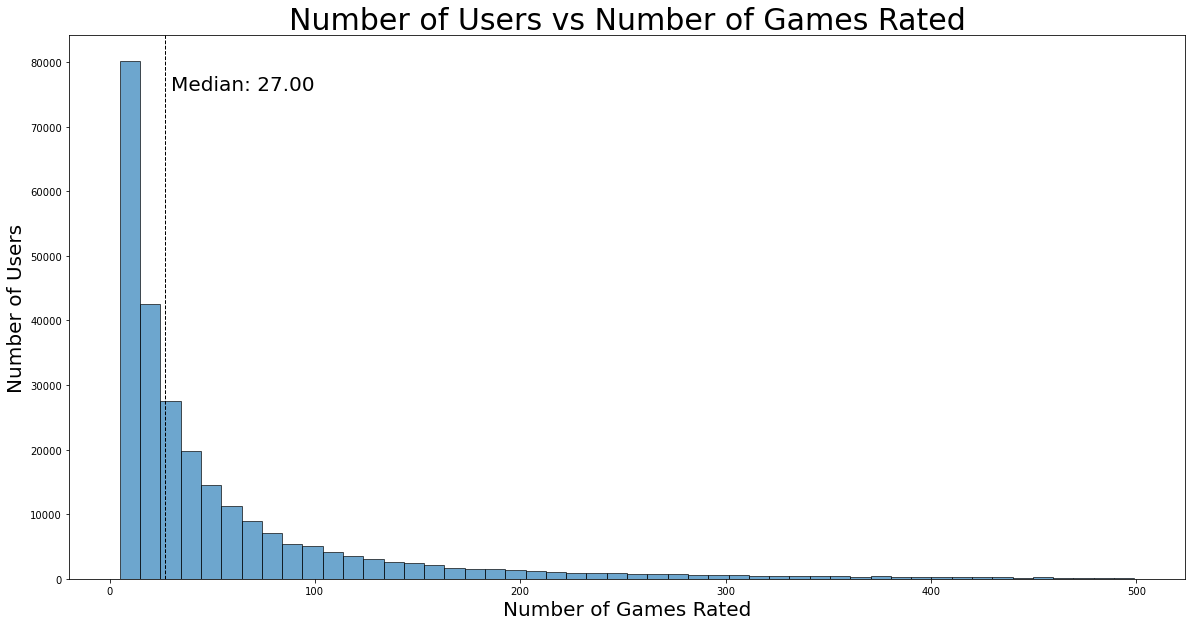

''

In [14]:
num_ratings = {}

for user in real_user_ratings_dictionary_scaled:
    num_ratings[user] = len(real_user_ratings_dictionary_scaled[user])
    
num_ratings_df = pd.DataFrame(num_ratings.values(), index=(num_ratings.keys())).reset_index()

fix, ax = plt.subplots(figsize=(20,10))

x = num_ratings_df.loc[num_ratings_df[0]<500][0]
med = num_ratings_df[0].median()

result = plt.hist(x, bins=50, edgecolor='k', alpha=0.65)
plt.axvline(med, color='k', linestyle='dashed', linewidth=1)

plt.title("Number of Users vs Number of Games Rated", fontsize=30)
plt.xlabel("Number of Games Rated", fontsize=20)
plt.ylabel("Number of Users", fontsize=20)

min_ylim, max_ylim = plt.ylim()
plt.text(med*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(med), fontsize=20)

#plt.savefig('images/usersvsrated.png')
plt.show()

;

In [15]:
# how many users under the median?

num_under_median = num_ratings_df.loc[num_ratings_df[0]<=43][0].count()
num_under_median_perc = round((num_under_median/num_ratings_df.shape[0]*100), 2)
print(str(num_under_median)+" users with 27 or fewer ratings (median), comprising "+str(num_under_median_perc)+"% of users.")

168128 users with 27 or fewer ratings (median), comprising 63.8% of users.


In [16]:
# how many users under 10 ratings?

num_under_10 = num_ratings_df.loc[num_ratings_df[0]<=10][0].count()
num_under_10_perc = round(num_under_10/num_ratings_df.shape[0]*100, 2)
print(str(num_under_10)+" users with 10 or fewer ratings (median), comprising "+str(num_under_10_perc)+"% of users.")

55570 users with 10 or fewer ratings (median), comprising 21.09% of users.


In [17]:
# make lists of users under and over the median from the dataframe
users_under_median = list(num_ratings_df.loc[num_ratings_df[0]<=27]['index'])
users_over_median = list(num_ratings_df.loc[num_ratings_df[0]>27]['index'])

# now make a new list of validation users that are under and over the median
val_under_median = [item for item in users_under_median if item in val_users]
val_over_median = [item for item in users_over_median if item in val_users]

## Memory Based

Use statistical techniques on the dataset to calculate the predictions.

In plain english, the memory model works by finding a subset of neighbors where we have v items in common. Then we calculate our cosine similarity with each member of the subset, using only our items in common. After picking the closest k neighbors, we make recommendations using items with at least n ratings within the subset.

We have several parameters to tune for the memory-based model for each of our data sets. They are:

* v: How many items do we need to have in common to be neighbors?
* k: How many closest neighbors do I want to consider for making new recommendations?
* n: How many of the k neighbors need to have rated an item in order for a rating to be produced for me?

Steps:

* For each user_a that we want to make recommendations for:

    * Find users_b who have rated v items in common
    * for each user_b:
    
        * Calculate intersection of ratings for user_a and user_b with v minimum items
        * calculate cosine similarity between user_a and user_b
    
    * Determine k closest neighbors_k based on cosine similarity
    * for each item_i in the games dictionary,
        
        * if neighbor_k rated item_i, get their rating (weighted by their similarity)
        * predicted rating for item_i is average of all neighbor's ratings
    
    * get accuracy metrics for user_a based on predictions vs actual for user_a rated items
    * sort predicted rating items and show x top recommendations

How do I evaluate my recommender? What we really want is a high RECALL in addition to a "reasonable" error. With that in mind it's more important to make sure that a user's actual items are correctly categorized as "recommended", defined as being over the user's mean. We're also interested in a good amount of catalog coverage, and still a reasonable error. To that end, our evaluation metric is a custom metric based on weighted scores of error, recall, and coverage.

In [47]:
# Opening JSON file
with open('user_means.json') as json_file:
    user_means = json.load(json_file)

In [23]:
# Opening JSON file
with open('userid_lookup_table.json') as json_file:
    userid_lookup_table = json.load(json_file)

In [18]:
# Opening JSON file
with open('user_blocks_lookup.json') as json_file:
    user_blocks_lookup = json.load(json_file)

In [101]:
# Opening JSON file
with open('real_ratings/similarity_storage_real_1.json') as json_file:
    similarity_storage_real = json.load(json_file)

In [237]:
user = 'Torsten'
user_mean = user_means[user]
user_mean

6.8

In [238]:
my_neighbors = similarity_storage_real[user]

In [248]:
user_predicted_ratings = {}
    
start = time.time()
    
weighted_ratings = {}

temp_dataframe = pd.DataFrame()

# for each user in my neighbors:
for neighbor in my_neighbors:
    neighbor_name = userid_lookup_table[neighbor]
    
    weighted_ratings[neighbor_name] = {}
       
    # for each item they rated:
    for item in real_user_ratings_dictionary_scaled[neighbor_name]:
        # weight their rating by similarity
        weighted_ratings[neighbor_name][item] = round((real_user_ratings_dictionary_scaled[neighbor_name][item] * my_neighbors[neighbor]),1)

In [249]:
%time temp_work = pd.DataFrame(weighted_ratings).T
temp_work

Wall time: 4.58 s


822   13  30549  319899  282421  282530  227143  284684  \
visard             3.3  0.8   -0.1    -0.1    -0.1    -0.1     2.4    -0.1   
Damlog             2.8  2.0    2.8     NaN     NaN     NaN     NaN     NaN   
FC Dynamo Turbine  1.0  3.0    1.0     NaN     NaN     NaN     NaN     NaN   
Master Thomas      1.4  1.4    1.4     NaN     NaN     NaN     NaN     NaN   
pboivin           -0.0  0.4    1.7     NaN     NaN     NaN     NaN     NaN   
...                ...  ...    ...     ...     ...     ...     ...     ...   
machetout          NaN  NaN    NaN     NaN     NaN     NaN     NaN     NaN   
neonzip            NaN  NaN    NaN     NaN     NaN     NaN     NaN     NaN   
philald            NaN  NaN    NaN     NaN     NaN     NaN     NaN     NaN   
Stig1972           NaN  NaN    NaN     NaN     NaN     NaN     NaN     NaN   
jlobato            NaN  NaN    NaN     NaN     NaN     NaN     NaN     NaN   

                   192814  231392  285128  186185  284949  220707  283848  \
visard               -0.1     0.8    -0.1    -1.7     0.8    -0.1     0.8   
Damlog                NaN     NaN     NaN     NaN     NaN     NaN     NaN   
FC Dynamo Turbine     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Master Thomas         NaN     NaN     NaN     NaN     NaN     NaN     NaN   
pboivin               NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...                   ...     ...     ...     ...     ...     ...     ...   
machetout             NaN     NaN     NaN     NaN     NaN     NaN     NaN   
neonzip               NaN     NaN     NaN     NaN     NaN     NaN     NaN   
philald               NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Stig1972              NaN     NaN     NaN     NaN     NaN     NaN     NaN   
jlobato               NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                   231611  283363  219511  277930  219717  194778  309341  \
visard               -1.7    -0.9    -1.7     1.6     0.8     1.6    -0.9   
Damlog                NaN     NaN     NaN     NaN     NaN     NaN     NaN   
FC Dynamo Turbine     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Master Thomas         NaN     NaN     NaN     NaN     NaN     NaN     NaN   
pboivin               NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...                   ...     ...     ...     ...     ...     ...     ...   
machetout             NaN     NaN     NaN     NaN     NaN     NaN     NaN   
neonzip               NaN     NaN     NaN     NaN     NaN     NaN     NaN   
philald               NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Stig1972              NaN     NaN     NaN     NaN     NaN     NaN     NaN   
jlobato               NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                   304821  219359  275626  341427  219502  184443  17313  \
visard                1.6    -0.9     3.3    -0.1    -0.9    -0.9   -0.9   
Damlog                NaN     NaN     NaN     NaN     NaN     NaN    NaN   
FC Dynamo Turbine     NaN     NaN     NaN     NaN     NaN     NaN    NaN   
Master Thomas         NaN     NaN     NaN     NaN     NaN     NaN    NaN   
pboivin               NaN    -1.1     NaN     NaN     NaN     NaN    NaN   
...                   ...     ...     ...     ...     ...     ...    ...   
machetout             NaN     NaN     NaN     NaN     NaN     NaN    NaN   
neonzip               NaN     NaN     NaN     NaN     NaN     NaN    NaN   
philald               NaN     NaN     NaN     NaN     NaN     NaN    NaN   
Stig1972              NaN     NaN     NaN     NaN     NaN     NaN    NaN   
jlobato               NaN     NaN     NaN     NaN     NaN     NaN    NaN   

                   17849  17773  15852  15855  15958  15427  16649  2793  \
visard              -2.5   -0.9   -0.9   -1.7   -0.9   -2.5   -0.1  -1.7   
Damlog               NaN    NaN   -4.0    NaN    NaN    NaN    NaN   NaN   
FC Dynamo Turbine    NaN    NaN    NaN    NaN    NaN    NaN    NaN   NaN   
Master Thomas  

In [252]:
n=15
%time over_n = temp_work.dropna(thresh=n, axis=1)

Wall time: 135 ms


In [253]:
over_n

822   13  30549  46396  28620  203780  27463  19427  \
visard             3.3  0.8   -0.1    2.4    1.6     1.6    1.6    1.6   
Damlog             2.8  2.0    2.8   -0.2    NaN     NaN    NaN    NaN   
FC Dynamo Turbine  1.0  3.0    1.0    1.0    NaN     NaN    NaN   -0.3   
Master Thomas      1.4  1.4    1.4    NaN    NaN     0.5    NaN    NaN   
pboivin           -0.0  0.4    1.7    NaN    NaN    -0.5    NaN    NaN   
...                ...  ...    ...    ...    ...     ...    ...    ...   
machetout          NaN  NaN    NaN    NaN    NaN     NaN    NaN    NaN   
neonzip            NaN  NaN    NaN    NaN    NaN     NaN    NaN    NaN   
philald            NaN  NaN    NaN    NaN    NaN     NaN    NaN    NaN   
Stig1972           NaN  NaN    NaN    NaN    NaN     NaN    NaN    NaN   
jlobato            NaN  NaN    NaN    NaN    NaN     NaN    NaN    NaN   

                   192934  316377  163805  304285  66214  128664  175878  \
visard                1.6     2.4     1.6     1.6    1.6     0.8     0.8   
Damlog                NaN     NaN     NaN     NaN    NaN     NaN     NaN   
FC Dynamo Turbine     NaN     NaN     NaN     NaN   -0.3     NaN     NaN   
Master Thomas         NaN     NaN     0.5     NaN    0.5     NaN     0.1   
pboivin               NaN     NaN     0.3     0.1    NaN     0.4    -0.2   
...                   ...     ...     ...     ...    ...     ...     ...   
machetout             NaN     NaN     NaN     NaN    NaN     NaN     NaN   
neonzip               NaN     NaN     NaN     NaN    NaN     NaN     NaN   
philald               NaN     NaN     NaN     NaN    NaN     NaN     NaN   
Stig1972              NaN     NaN     NaN     NaN    NaN     NaN     NaN   
jlobato               NaN     NaN     NaN     NaN    NaN     NaN     NaN   

                   212516  169611  23451  27048  230304   19  32484  145203  \
visard                1.6     1.6    0.8    0.8     0.8  0.8    0.8     0.8   
Damlog                NaN     NaN    NaN    NaN     NaN  1.3   -1.0    -1.0   
FC Dynamo Turbine     NaN     NaN    1.0    NaN     NaN  2.3    NaN     NaN   
Master Thomas         0.5     NaN    0.1    NaN     NaN  0.5    NaN     NaN   
pboivin               NaN     0.1    NaN    NaN     NaN  NaN    NaN     0.2   
...                   ...     ...    ...    ...     ...  ...    ...     ...   
machetout             NaN     NaN    NaN    NaN     NaN  NaN    NaN     NaN   
neonzip               NaN     NaN    NaN    NaN     NaN  NaN    NaN     NaN   
philald               NaN     NaN    NaN    NaN     NaN  NaN    NaN     NaN   
Stig1972              NaN     NaN    NaN    NaN     NaN  NaN    NaN     NaN   
jlobato               NaN     NaN    NaN    NaN     NaN  NaN    NaN     NaN   

                   180198  153318  265683  38548  233955  38531  41833  94480  \
visard                0.8     0.8     0.8    0.8     0.8    0.8   -0.1    0.8   
Damlog                NaN     NaN    -0.2   -0.2     NaN    NaN   -1.7    NaN   
FC Dynamo Turbine     NaN     NaN     NaN    NaN     NaN    0.3   -1.0    1.0   
Master Thomas         NaN     NaN     NaN    0.1     0.5    0.5    NaN    0.1   
pboivin               NaN    -0.5    -0.5    NaN     0.1    NaN    0.3    0.0   
...                   ...     ...     ...    ...     ...    ...    ...    ...   
machetout             NaN     NaN     NaN    NaN     NaN    NaN    NaN    NaN   
neonzip               NaN     NaN     NaN    NaN     NaN    NaN    NaN    NaN   
philald               NaN     NaN     NaN    NaN     NaN    NaN    NaN    NaN   
Stig1972              NaN     NaN     NaN    NaN     NaN    NaN    NaN    NaN   
jlobato               NaN     NaN     NaN    NaN     NaN    NaN    NaN    NaN   

                   111  15878  10799  31133  31624  140717  129050  104955  \
visard             0.8   -0.1   -1.7    0.8    0.8     0.8     0.8     0.8   
Damlog             NaN    0.5   -3.2    NaN    NaN     1.3     NaN     NaN   
FC Dynamo Turbine  0.3    NaN    NaN    NaN   -0.3    -1.0   

In [254]:
%time df2 = round((over_n.loc[:,round(over_n.mean(axis=0),1) > 0].mean()), 1).sort_values(ascending=False)+user_mean
df2.head(30)

Wall time: 121 ms


70149     8.2
271320    7.9
108687    7.9
28185     7.8
200680    7.8
555       7.7
31260     7.7
107529    7.7
36218     7.7
40834     7.7
229220    7.7
55670     7.7
136888    7.7
13        7.7
245934    7.6
127060    7.6
146886    7.6
148228    7.6
18602     7.6
172386    7.6
137408    7.6
3307      7.6
2338      7.6
22545     7.6
119890    7.6
93538     7.6
31627     7.6
300327    7.6
183840    7.6
30957     7.5
dtype: float64

In [227]:
user_predicted_ratings = df2.to_dict()

# print a report about the user
total_ratings_created = len(user_predicted_ratings)
print("Predicted "+str(total_ratings_created)+' ratings')

Predicted 2324 ratings


### Finding Optimal v, k and n

This section involves iterative grid searching on the previously mentioned parameters v, k and n. The search is performed on a smaller subset of 100 users. Not all searches are present in the cell below; search scores are tracked and saved to file and then reset in the same cell.

In [ ]:
# set up distance dictionary to populate which is a dictionary with an empty entry per user
real_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    real_distance_dictionary[user] = {}

In [255]:
# set up score lists for grid searching, will append
vs_and_ks = []
mae_tracker = []
rmse_tracker = []
recall_tracker = []
mean_number = []
median_number = []
catalog_coverage = []

In [256]:
real_user_ratings_dictionary_scaled['Torsten']

{'30549': 3.21,
 '822': 3.21,
 '13': 3.21,
 '193134': 0.21,
 '17181': -1.29,
 '17994': 0.21,
 '18056': 0.21,
 '1011': -1.79,
 '1975': -0.79,
 '1879': 0.71,
 '1938': -1.29,
 '1947': -1.79,
 '2295': -2.79,
 '2176': -1.79,
 '1534': -0.79,
 '1547': -0.79,
 '1396': -1.79,
 '7693': -4.79,
 '136089': 0.21,
 '135327': -0.29,
 '137358': -1.79,
 '148528': 0.71,
 '146152': 0.21,
 '147920': 0.21,
 '148000': -1.29,
 '118258': -0.29,
 '110245': -1.79,
 '110598': -2.79,
 '108156': -1.79,
 '130520': -0.29,
 '129952': -0.79,
 '132616': 0.21,
 '133524': -0.79,
 '129053': -0.79,
 '174468': -2.79,
 '171087': -3.79,
 '171494': -0.29,
 '154274': -0.79,
 '164566': -1.29,
 '35468': -3.79,
 '33383': -0.79,
 '37777': -0.79,
 '24826': -2.79,
 '24977': -1.79,
 '30640': -2.79,
 '31111': -1.79,
 '28755': -0.79,
 '89915': -2.79,
 '90016': -1.79,
 '84776': -0.29,
 '84913': -0.79,
 '84991': 0.21,
 '106836': -2.79,
 '104553': -0.79,
 '93555': -0.79,
 '54501': -0.79,
 '53723': 0.71,
 '56759': -0.79,
 '60682': -1.79,
 '6

In [257]:
# make our test set of 100 users
test_set = val_users[:5]

dictionary_set = [real_user_ratings_dictionary_scaled, real_user_ratings_dictionary_unscaled]

# searching the grid of v/k/n
for n in [30, 25, 20, 15, 10, 5, 3, 2]:
    start = time.time()
    string = 'n'+str(n)
    print("Calculating for "+string)
    # This is the big function call which scores the set of users for given v, k, n
    global_scores, user_predictions_real_basismemory, all_recommended_items = get_user_predictions(dictionary_set, test_set, n, synth=False)
    vs_and_ks.append(string)
    mae_tracker.append(global_scores[0])
    rmse_tracker.append(global_scores[1])
    recall_tracker.append(global_scores[2])
    mean_number.append(global_scores[3])
    median_number.append(global_scores[4])
    end = time.time() - start
    coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)
    catalog_coverage.append(coverage)


Calculating for n30
Calculating Torsten
Predicted 646 ratings
Calculating mitnachtKAUBO-I
Predicted 1231 ratings
Calculating avlawn
Predicted 924 ratings
Calculating Mike Mayer
Predicted 1012 ratings
Calculating Mease19
Predicted 1497 ratings
MAE for set of users: 0.9582478548718855
RMSE for set of users: 1.2457052347274749
Recall for set of users: 100.0
Average/Median Number Recommended Items: 1062, 1012
Time elapsed: 65.6896698474884
Calculating for n25
Calculating Torsten
Predicted 764 ratings
Calculating mitnachtKAUBO-I
Predicted 1409 ratings
Calculating avlawn
Predicted 1059 ratings
Calculating Mike Mayer
Predicted 1167 ratings
Calculating Mease19
Predicted 1615 ratings
MAE for set of users: 0.9413919388447145
RMSE for set of users: 1.2297273073683148
Recall for set of users: 100.0
Average/Median Number Recommended Items: 1202.8, 1167
Time elapsed: 67.30854558944702
Calculating for n20
Calculating Torsten
Predicted 960 ratings
Calculating mitnachtKAUBO-I
Predicted 1596 ratings
Cal

In [259]:
zipped = list(zip(mae_tracker, rmse_tracker, recall_tracker, mean_number, median_number, catalog_coverage))
scores = pd.DataFrame(zipped, index=vs_and_ks, columns=['MAE', 'RMSE', 'Recall', 'Mean Ratings', 'Median Ratings', 'Coverage']).sort_values('RMSE')
#scores.to_pickle('scores/real_scores_round1.pkl')

In [236]:
scores

MAE      RMSE  Recall  Mean Ratings  Median Ratings  Coverage
n2   0.904819  1.182908   100.0        5724.6            5814     61.32
n3   0.905165  1.183134   100.0        4618.8            4663     49.67
n10  0.904527  1.186361   100.0        2140.8            2052     20.33
n5   0.908234  1.186920   100.0        3335.8            3286     34.30
n15  0.913606  1.197517   100.0        1667.2            1607     15.06

In [ ]:
scores = pd.read_pickle('scores/real_scores_round1.pkl')

error_weight = 1
recall_weight = 1
coverage_weight = 1
median_weight = 0

scores['MAE_Scale'] = ((1-scores['MAE'])*100)*error_weight
scores['Median_Scale'] = (scores['Median Ratings']/100)*median_weight
scores['Recall_Scale'] = scores['Recall']*recall_weight
scores['Coverage_Scale'] = (scores['Coverage']/10)*coverage_weight


scores['Score'] = (scores['Median Ratings']/100)*median_weight + ((1-scores['MAE'])*100)*error_weight + scores['Recall']*recall_weight + (scores['Coverage']/10)*coverage_weight
scores.sort_values('Score', ascending=False).head(30) #scores['Median Ratings']/100*median_weight +


v5_k250_n10	0.505076	0.647022	64.0862	740.04	401.5	30.19	49.492426	0.0	64.0862	3.019	116.597626

### Get Validation Scores

In [ ]:
# define best v, k, n

real_mae = []
real_rmse = []
real_recall = []
real_mean_number = []
real_median_number = []
real_coverage = []

In [ ]:
# define v, k, n
v, k, n = 5, 250, 10
parameters = [v, k, n]

In [ ]:
# set up distance dictionary to populate which is a dictionary with an empty entry per user
real_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    real_distance_dictionary[user] = {}

In [ ]:
# get the scores for the entire validation set
dictionary_set = [real_user_ratings_dictionary_scaled, real_user_ratings_dictionary_unscaled, real_distance_dictionary]

real_scores, user_predictions_real_basismemory, items_in_set = get_user_predictions(dictionary_set, val_users, parameters, synth=False)

coverage = round(((len(items_in_set)/len(game_id_lookup))*100), 2)


real_mae.append(real_scores[0])
real_rmse.append(real_scores[1])
real_recall.append(real_scores[2])
real_mean_number.append(real_scores[3])
real_median_number.append(real_scores[4])
real_coverage.append(coverage)

In [ ]:
print("MAE for set of users: "+str(global_mae))
print("RMSE for set of users: "+str(global_rmse))
print("Recall for set of users: "+str(global_recall))
print("Coverage for set of users: "+str(coverage))

In [ ]:
# get the scores for only the validation set UNDER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in val_under_median:
    user_mean = user_mean_lookup[user]['user_mean']
    user_predicted_ratings = user_predictions_real_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean)
    
    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue
    
    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

    
under_mae = mean(global_mae_list)
under_rmse = mean(global_rmse_list)
under_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)

real_mae.append(under_mae)
real_rmse.append(under_rmse)
real_recall.append(under_recall)
real_coverage.append(coverage)

In [ ]:
print("MAE for set of users: "+str(under_mae))
print("RMSE for set of users: "+str(under_rmse))
print("Recall for set of users: "+str(under_recall))
print("Coverage for set of users: "+str(coverage))

In [ ]:
# get the scores for only the validation set OVER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in val_over_median:
    user_mean = user_mean_lookup[user]['user_mean']
    user_predicted_ratings = user_predictions_real_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean)
    
    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue
    
    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

    
over_mae = mean(global_mae_list)
over_rmse = mean(global_rmse_list)
over_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)


real_mae.append(over_mae)
real_rmse.append(over_rmse)
real_recall.append(over_recall)
real_coverage.append(coverage)

In [ ]:
print("MAE for set of users: "+str(over_mae))
print("RMSE for set of users: "+str(over_rmse))
print("Recall for set of users: "+str(over_recall))
print("Coverage for set of users: "+str(coverage))

In [ ]:
# Check out our scores for our different subsets
indices = ['Full Validation', 'Under Median', 'Over Median']
scores_real = pd.DataFrame(
    {'MAE': real_mae,
     'RMSE': real_rmse,
     'Recall': real_recall,
     'Coverage': real_coverage,
    }, index=indices)
scores_real

In [ ]:
# weight our scores for our overall score
scores_real=pd.read_pickle('val_scores_real.pkl')
scores_real['Score'] = ((1-scores_real['RMSE'])*100)*error_weight + scores_real['Recall']*recall_weight + (scores_real['Coverage'])*coverage_weight
scores_real.sort_values('Score', ascending=False).head(30)


In [ ]:
# save scores to file
scores_real.to_pickle('val_scores_real.pkl')

In [ ]:
# save predictions to file
with open('user_predictions_real_basismemory.json', 'w') as convert_file:
     convert_file.write(json.dumps(user_predictions_real_basismemory))

In [ ]:
# save catalog to file
with open('items_in_set_real.json', 'w') as convert_file:
     convert_file.write(json.dumps(recommended_items))

### Clean Up

In [ ]:
del real_user_ratings_dictionary_scaled
del real_user_ratings_dictionary_unscaled
del user_predictions_real_basismemory
del user_predictions_realundermed_basismemory
del user_predictions_realovermed_basismemory
del items_in_set_real
del items_in_set_real_under
del items_in_set_real_over
del real_distance_dictionary
del real_user_ratings_dictionary_scaled
del real_user_ratings_dictionary_unscaled


gc.collect()

# Tests with Synthetic Data

## Memory Based - 50 Ratings

In [ ]:
# Opening JSON file
with open('synthetic_ratings/synth_user_ratings_dictionary_scaled_50.json') as json_file:
    synth_user_ratings_dictionary_scaled50 = json.load(json_file)

### Visualizations

Create a visualization showing the number of users vs number of games rated, with a line at the median. We can see how our median has changed now that we have synthetic data.

In [ ]:
num_ratings = {}

for user in synth_user_ratings_dictionary_scaled50:
    num_ratings[user] = len(synth_user_ratings_dictionary_scaled50[user])
    
num_ratings_df = pd.DataFrame(num_ratings.values(), index=(num_ratings.keys())).reset_index()

fix, ax = plt.subplots(figsize=(20,10))

x = num_ratings_df.loc[num_ratings_df[0]<500][0]
med = num_ratings_df[0].median()

result = plt.hist(x, bins=50, edgecolor='k', alpha=0.65)
plt.axvline(med, color='k', linestyle='dashed', linewidth=1)

plt.title("Number of Users vs Number of Games Rated (Synth 100)", fontsize=30)
plt.xlabel("Number of Games Rated", fontsize=20)
plt.ylabel("Number of Users", fontsize=20)

min_ylim, max_ylim = plt.ylim()
plt.text(med*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(med), fontsize=20)

#plt.savefig('images/synth_usersvsrated.png')
plt.show()

;

In [ ]:
num_under_50 = num_ratings_df.loc[num_ratings_df[0]==50][0].count()
num_under_50_perc = round(num_under_50/num_ratings_df.shape[0]*100, 2)
print(str(num_under_50)+" users with 50 or fewer ratings (median), comprising "+str(num_under_50_perc)+"% of users.")

We now have 73.54% of users with only 100 ratings.

### Finding Optimal v, k and n

In [ ]:
synth50_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    synth50_distance_dictionary[user] = {}

In [ ]:
dictionary_set = [synth_user_ratings_dictionary_scaled50, real_user_ratings_dictionary_unscaled, synth50_distance_dictionary]

In [ ]:
vs_and_ks50 = []
mae_tracker50 = []
rmse_tracker50 = []
recall_tracker50 = []
mean_tracker50 = []
meadian_tracker50 = []
catalog_coverage50 = []

In [ ]:
user_set = val_users[:100]

for v in [25, 20, 15, 10, 7, 5, 3]:
    for k in [250]: # K only to make sure we have enough neighbors at the v
        for n in [15, 10, 5, 3, 2]:
            parameters = [v, k, n]
            start = time.time()
            string = 'v'+str(v)+'_k'+str(k)+'_n'+str(n)
            print("Calculating for "+string)
            global_scores,  user_predictions_synth_basismemory, catalog_temp = get_user_predictions(dictionary_set, user_set, parameters, synth=True)
            vs_and_ks50.append(string)
            mae_tracker50.append(global_scores[0])
            rmse_tracker50.append(global_scores[1])
            recall_tracker50.append(global_scores[2])
            mean_tracker50.append(global_scores[3])
            meadian_tracker50.append(global_scores[4])
            end = time.time() - start
            coverage = round(((len(catalog_temp)/len(game_id_lookup))*100), 2)
            catalog_coverage50.append(coverage)

In [ ]:
zipped = list(zip(mae_tracker50, rmse_tracker50, recall_tracker50, mean_tracker50, meadian_tracker50, catalog_coverage50))
scores = pd.DataFrame(zipped, index=vs_and_ks50, columns=['MAE', 'RMSE', 'Recall', 'Mean Ratings', 'Median Ratings', 'Coverage']).sort_values('RMSE')
scores.to_pickle('scores/new_synth50_scores_round1.pkl')

In [ ]:
synth50scores = pd.read_pickle('scores/new_synth50_scores_round1.pkl')

error_weight = 1
recall_weight = 1
coverage_weight = 1
median_weight = 0

synth50scores['MAE_Scale'] = ((1-synth50scores['MAE'])*100)*error_weight
synth50scores['Recall_Scale'] = synth50scores['Recall']*recall_weight
synth50scores['Coverage_Scale'] = (synth50scores['Coverage']/10)*coverage_weight

synth50scores['Score'] = ((1-synth50scores['MAE'])*100)*error_weight + synth50scores['Recall']*recall_weight + (synth50scores['Coverage']/10)*coverage_weight
synth50scores.sort_values('Score', ascending=False).head(30)

We now run the exact same series of Memory-based and Model-based tests, only with our Synthetic data set.

## Memory Based - 100 Ratings

In [ ]:
# Opening JSON file
with open('synthetic_ratings/synth_user_ratings_dictionary_scaled_100.json') as json_file:
    synth_user_ratings_dictionary_scaled100 = json.load(json_file)

### Visualizations

Create a visualization showing the number of users vs number of games rated, with a line at the median. We can see how our median has changed now that we have synthetic data.

In [ ]:
num_ratings = {}

for user in synth_user_ratings_dictionary_scaled100:
    num_ratings[user] = len(synth_user_ratings_dictionary_scaled100[user])
    
num_ratings_df = pd.DataFrame(num_ratings.values(), index=(num_ratings.keys())).reset_index()

fix, ax = plt.subplots(figsize=(20,10))

x = num_ratings_df.loc[num_ratings_df[0]<500][0]
med = num_ratings_df[0].median()

result = plt.hist(x, bins=50, edgecolor='k', alpha=0.65)
plt.axvline(med, color='k', linestyle='dashed', linewidth=1)

plt.title("Number of Users vs Number of Games Rated (Synth 100)", fontsize=30)
plt.xlabel("Number of Games Rated", fontsize=20)
plt.ylabel("Number of Users", fontsize=20)

min_ylim, max_ylim = plt.ylim()
plt.text(med*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(med), fontsize=20)

#plt.savefig('images/synth_usersvsrated.png')
plt.show()

;

In [ ]:
num_under_100 = num_ratings_df.loc[num_ratings_df[0]==100][0].count()
num_under_100_perc = round(num_under_100/num_ratings_df.shape[0]*100, 2)
print(str(num_under_100)+" users with 100 or fewer ratings (median), comprising "+str(num_under_100_perc)+"% of users.")

We now have 73.54% of users with only 100 ratings.

### Finding Optimal v, k and n

In [ ]:
synth100_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    synth100_distance_dictionary[user] = {}

In [ ]:
dictionary_set = [synth_user_ratings_dictionary_scaled100, real_user_ratings_dictionary_unscaled, synth100_distance_dictionary]

In [ ]:
vs_and_ks100 = []
mae_tracker100 = []
rmse_tracker100 = []
recall_tracker100 = []
mean_tracker100 = []
meadian_tracker100 = []
catalog_coverage100 = []

In [ ]:
user_set = val_users[:100]

for v in [25, 20, 15, 10, 7, 5, 3]:
    for k in [250]: # K only to make sure we have enough neighbors at the v
        for n in [15, 10, 5, 3, 2]:
            parameters = [v, k, n]
            start = time.time()
            string = 'v'+str(v)+'_k'+str(k)+'_n'+str(n)
            print("Calculating for "+string)
            global_scores,  user_predictions_synth_basismemory, catalog_temp = get_user_predictions(dictionary_set, user_set, parameters, synth=True)
            vs_and_ks100.append(string)
            mae_tracker100.append(global_scores[0])
            rmse_tracker100.append(global_scores[1])
            recall_tracker100.append(global_scores[2])
            mean_tracker100.append(global_scores[3])
            meadian_tracker100.append(global_scores[4])
            end = time.time() - start
            coverage = round(((len(catalog_temp)/len(game_id_lookup))*100), 2)
            catalog_coverage100.append(coverage)

In [ ]:
zipped = list(zip(mae_tracker100, rmse_tracker100, recall_tracker100, mean_tracker100, meadian_tracker100, catalog_coverage100))
scores = pd.DataFrame(zipped, index=vs_and_ks100, columns=['MAE', 'RMSE', 'Recall', 'Mean Ratings', 'Median Ratings', 'Coverage']).sort_values('RMSE')
scores.to_pickle('scores/new_synth100_scores_round1.pkl')

In [ ]:
synth100scores = pd.read_pickle('scores/new_synth100_scores_round1.pkl')

error_weight = .2
recall_weight = 1
coverage_weight = 0
median_weight = 0

synth100scores['Score'] = synth100scores['Median Ratings']/1000*median_weight + ((1-synth100scores['MAE']))*error_weight + synth100scores['Recall']/100*recall_weight + (synth100scores['Coverage']/100)*coverage_weight
synth100scores.sort_values('Score', ascending=False).head(30)


### Get Validation Scores

In final round testing, I'm observing if our synthetic data additions have improved the group I was most interested in improving to begin with - the users below the median. We run our optimal v/k/n with the validation set of each of these groups to determine if we continue with this synthetic data set. 

In [ ]:
parameters = [5, 250, 5]

In [ ]:
synth100_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    synth100_distance_dictionary[user] = {}

In [ ]:
dictionary_set = [synth_user_ratings_dictionary_scaled100, real_user_ratings_dictionary_unscaled, synth100_distance_dictionary]

In [ ]:
# define best v, k, n

synth100_mae = []
synth100_rmse = []
synth100_recall = []
synth100_coverage = []

In [ ]:
# get distance between users and store in dict

global_mae, global_rmse, global_recall, user_predictions_synth100_basismemory, item_set_synth100 = get_user_predictions(dictionary_set, val_users, parameters, synth=True)

synth100_mae.append(global_mae)
synth100_rmse.append(global_rmse)
synth100_recall.append(global_recall)

coverage = round(((len(item_set_synth100)/len(game_id_lookup))*100), 2)
synth100_coverage.append(coverage)

In [ ]:
print("MAE for set of users: "+str(global_mae))
print("RMSE for set of users: "+str(global_rmse))
print("Recall for set of users: "+str(global_recall))
print("Coverage for set of users: "+str(coverage))

In [ ]:
with open('user_predictions_synth100_basismemory.json', 'w') as convert_file:
     convert_file.write(json.dumps(user_predictions_synth100_basismemory))

In [ ]:
# save catalog to file
with open('item_set_synth100.json', 'w') as convert_file:
     convert_file.write(json.dumps(item_set_synth100))

In [ ]:
# get the scores for only the validation set UNDER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in val_under_median:
    user_mean = user_mean_lookup[user]['user_mean']
    user_predicted_ratings = user_predictions_synth100_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean)
    
    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue
    
    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

    
under_mean = mean(global_mae_list)
under_rmse = mean(global_rmse_list)
under_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)


synth100_mae.append(under_mean)
synth100_rmse.append(under_rmse)
synth100_recall.append(under_recall)
synth100_coverage.append(coverage)

In [ ]:
print("MAE for set of users: "+str(under_mae))
print("RMSE for set of users: "+str(under_rmse))
print("Recall for set of users: "+str(under_recall))
print("Coverage for set of users: "+str(coverage))

In [ ]:
# get the scores for only the validation set OVER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in val_over_median:
    user_mean = user_mean_lookup[user]['user_mean']
    user_predicted_ratings = user_predictions_synth100_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean)
    
    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue
    
    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

    
over_mae = mean(global_mae_list)
over_rmse = mean(global_rmse_list)
over_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)


synth100_mae.append(over_mae)
synth100_rmse.append(over_rmse)
synth100_recall.append(over_recall)
synth100_coverage.append(coverage)

In [ ]:
print("MAE for set of users: "+str(over_mae))
print("RMSE for set of users: "+str(over_rmse))
print("Recall for set of users: "+str(over_recall))
print("Coverage for set of users: "+str(coverage))

In [ ]:
indices = ['Full Validation', 'Under Median', 'Over Median']
scores_synth100 = pd.DataFrame(
    {'MAE': synth100_mae,
     'RMSE': synth100_rmse,
     'Recall': synth100_recall,
     'Coverage':synth100_coverage,
    }, index=indices)
scores_synth100

In [ ]:
# save scores to file
scores_synth100.to_pickle('val_scores_synth100.pkl')

In [ ]:
scores_synth100=pd.read_pickle('val_scores_synth100.pkl')
scores_synth100['Score'] = ((1-scores_synth100['RMSE'])*100)*error_weight + scores_synth100['Recall']*recall_weight + (scores_synth100['Coverage'])*coverage_weight
scores_synth100.sort_values('Score', ascending=False).head(30)

## Memory Based - 250 Ratings

In [ ]:
# Opening JSON file
with open('synthetic_ratings/synth_user_ratings_dictionary_scaled_250.json') as json_file:
    synth_user_ratings_dictionary_scaled250 = json.load(json_file)

### Visualizations

Create a visualization showing the number of users vs number of games rated, with a line at the median. We can see how our median has changed now that we have synthetic data.

In [ ]:
num_ratings = {}

for user in synth_user_ratings_dictionary_scaled250:
    num_ratings[user] = len(synth_user_ratings_dictionary_scaled250[user])
    
num_ratings_df = pd.DataFrame(num_ratings.values(), index=(num_ratings.keys())).reset_index()

fix, ax = plt.subplots(figsize=(20,10))

x = num_ratings_df.loc[num_ratings_df[0]<500][0]
med = num_ratings_df[0].median()

result = plt.hist(x, bins=50, edgecolor='k', alpha=0.65)
plt.axvline(med, color='k', linestyle='dashed', linewidth=1)

plt.title("Number of Users vs Number of Games Rated (Synth 250)", fontsize=30)
plt.xlabel("Number of Games Rated", fontsize=20)
plt.ylabel("Number of Users", fontsize=20)

min_ylim, max_ylim = plt.ylim()
plt.text(med*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(med), fontsize=20)

#plt.savefig('images/synth_usersvsrated.png')
plt.show()

;

In [ ]:
num_under_250 = num_ratings_df.loc[num_ratings_df[0]==250][0].count()
num_under_250_perc = round(num_under_250/num_ratings_df.shape[0]*100, 2)
print(str(num_under_250)+" users with 250 or fewer ratings (median), comprising "+str(num_under_250_perc)+"% of users.")

We now have 73.54% of users with only 100 ratings.

### Finding Optimal v, k and n

In [ ]:
synth250_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    synth250_distance_dictionary[user] = {}

In [ ]:
dictionary_set = [synth_user_ratings_dictionary_scaled250, real_user_ratings_dictionary_unscaled, synth250_distance_dictionary]

In [ ]:
vs_and_ks250 = []
mae_tracker250 = []
rmse_tracker250 = []
recall_tracker250 = []
mean_tracker250 = []
meadian_tracker250 = []
catalog_coverage250 = []

In [ ]:
user_set = val_users[:100]

for v in [25, 20, 15, 10, 7, 5, 3]:
    for k in [250]: # K only to make sure we have enough neighbors at the v
        for n in [15, 10, 5, 3, 2]:
            parameters = [v, k, n]
            start = time.time()
            string = 'v'+str(v)+'_k'+str(k)+'_n'+str(n)
            print("Calculating for "+string)
            global_scores,  user_predictions_synth_basismemory, catalog_temp = get_user_predictions(dictionary_set, user_set, parameters, synth=True)
            vs_and_ks250.append(string)
            mae_tracker250.append(global_scores[0])
            rmse_tracker250.append(global_scores[1])
            recall_tracker250.append(global_scores[2])
            mean_tracker250.append(global_scores[3])
            meadian_tracker250.append(global_scores[4])
            end = time.time() - start
            coverage = round(((len(catalog_temp)/len(game_id_lookup))*100), 2)
            catalog_coverage250.append(coverage)

In [ ]:
zipped = list(zip(mae_tracker250, rmse_tracker250, recall_tracker250, mean_tracker250, meadian_tracker250, catalog_coverage250))
scores = pd.DataFrame(zipped, index=vs_and_ks250, columns=['MAE', 'RMSE', 'Recall', 'Mean Ratings', 'Median Ratings', 'Coverage']).sort_values('RMSE')
scores.to_pickle('scores/new_synth250_scores_round1.pkl')

In [ ]:
synth250scores = pd.read_pickle('scores/new_synth250_scores_round1.pkl')

error_weight = .2
recall_weight = 1
coverage_weight = 0
median_weight = 0

synth250scores['Score'] = synth250scores['Median Ratings']/1000*median_weight + ((1-synth250scores['MAE']))*error_weight + synth250scores['Recall']/100*recall_weight + (synth250scores['Coverage']/100)*coverage_weight
synth250scores.sort_values('Score', ascending=False).head(30)

# Different Memory Scores

In [ ]:
scores = pd.read_pickle('scores/real_scores_round1.pkl')
synth50scores_realk = pd.read_pickle('scores/new_synth50_scores_round1_realk.pkl')
synth100scores_realk = pd.read_pickle('scores/new_synth100_scores_round1_realk.pkl')
synth250scores_realk = pd.read_pickle('scores/new_synth250_scores_round1_realk.pkl')
synth50scores = pd.read_pickle('scores/new_synth50_scores_round1.pkl')
synth100scores = pd.read_pickle('scores/new_synth100_scores_round1.pkl')
synth250scores = pd.read_pickle('scores/new_synth250_scores_round1.pkl')

In [ ]:
error_weight = .2
recall_weight = 1
coverage_weight = 0
median_weight = 0

In [ ]:
scores['Score'] = scores['Median Ratings']/1000*median_weight + ((1-scores['MAE']))*error_weight + scores['Recall']/100*recall_weight + (scores['Coverage']/100)*coverage_weight
scores.sort_values('Score', ascending=False).head(7) #scores['Median Ratings']/100*median_weight +

In [ ]:
synth50scores['Score'] = synth50scores['Median Ratings']/1000*median_weight + ((1-synth50scores['MAE']))*error_weight + synth50scores['Recall']/100*recall_weight + (synth50scores['Coverage']/100)*coverage_weight
synth50scores.sort_values('Score', ascending=False).head(7)

In [ ]:
synth50scores_realk['Score'] = synth50scores_realk['Median Ratings']/1000*median_weight + ((1-synth50scores_realk['MAE']))*error_weight + synth50scores_realk['Recall']/100*recall_weight + (synth50scores_realk['Coverage']/100)*coverage_weight
synth50scores_realk.sort_values('Score', ascending=False).head(7)

In [ ]:
synth100scores['Score'] = synth100scores['Median Ratings']/1000*median_weight + ((1-synth100scores['MAE']))*error_weight + synth100scores['Recall']/100*recall_weight + (synth100scores['Coverage']/100)*coverage_weight
synth100scores.sort_values('Score', ascending=False).head(7)

In [ ]:
synth100scores_realk['Score'] = synth100scores_realk['Median Ratings']/1000*median_weight + ((1-synth100scores_realk['MAE']))*error_weight + synth100scores_realk['Recall']/100*recall_weight + (synth100scores_realk['Coverage']/100)*coverage_weight
synth100scores_realk.sort_values('Score', ascending=False).head(7)

In [ ]:
synth250scores['Score'] = synth250scores['Median Ratings']/1000*median_weight + ((1-synth250scores['MAE']))*error_weight + synth250scores['Recall']/100*recall_weight + (synth250scores['Coverage']/100)*coverage_weight
synth250scores.sort_values('Score', ascending=False).head(7)

In [ ]:
synth250scores_realk['Score'] = synth250scores_realk['Median Ratings']/1000*median_weight + ((1-synth250scores_realk['MAE']))*error_weight + synth250scores_realk['Recall']/100*recall_weight + (synth250scores_realk['Coverage']/100)*coverage_weight
synth250scores_realk.sort_values('Score', ascending=False).head(7)

# Single User Testing

In [ ]:
user = 'Szczurek83'
user_mean = user_mean_lookup[user]['user_mean']

In [ ]:
user = 'Threnody'
user_mean = user_mean_lookup[user]['user_mean']

In [ ]:
# Opening JSON file
with open('real_ratings/real_user_ratings_dictionary_scaled.json') as json_file:
    real_user_ratings_dictionary_scaled = json.load(json_file)

In [ ]:
# Opening JSON file
with open('real_ratings/real_user_ratings_dictionary_unscaled.json') as json_file:
    real_user_ratings_dictionary_unscaled = json.load(json_file)

In [ ]:
# make a list of all actual rated item ids
actual_rated_items = list(real_user_ratings_dictionary_scaled[user].keys())
names = {}

# for each item in the recommentation list,
for item in actual_rated_items:
    
    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    names[item_name] = real_user_ratings_dictionary_scaled[user][item]

names

## Real Data

In [ ]:
temp_dict = {}
for person in real_user_ratings_dictionary_scaled:
    temp_dict[person] = {}

In [ ]:
resources_pack = [real_user_ratings_dictionary_scaled, real_user_ratings_dictionary_unscaled, temp_dict]
v, k, n = 5, 250, 15
parameters = [v, k, n]

In [ ]:
# unpack the resources pack
all_users_ratings = resources_pack[0]
real_users_ratings = resources_pack[1]
this_dictionary = resources_pack[2]

    
# make a list of the user_a reviewed items
user_items = list(all_users_ratings[user].keys())
    
# make a distance dictionary for this user
similarity_dictionary={}
        
similarity_dictionary = get_user_similarity(this_dictionary, user, all_users_ratings, user_items, v)

In [ ]:
len(similarity_dictionary)

In [ ]:
sim_group = pd.DataFrame(similarity_dictionary.values(), index=similarity_dictionary.keys())
sim_group.sort_values(0, ascending=False)[:250]

In [ ]:
# score user
scores, this_user_predictions, item_set = get_user_predictions(resources_pack, [user], parameters, synth=False)

In [ ]:
user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], this_user_predictions[user], user_mean)

In [ ]:
user_mae, user_rmse, recall

In [ ]:
actuals_list = [item for item in this_user_predictions if item in actual_rated_items]
for item in actuals_list:
    print("Actual: "+str(real_user_ratings_dictionary_unscaled[user][item])+"\tPredicted: "+str(this_user_predictions[user][item]))

In [ ]:
# the recommendations list of items that were predicted that were not actually rated
new_recommendations_list = [item for item in this_user_predictions[user] if item not in actual_rated_items]
new_recommendations_list

# make a dictionary for new recommendations
new_recommended_items = {}

# for each item in the recommentation list,
for item in new_recommendations_list:
    
    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    new_recommended_items[item_name] = this_user_predictions[user][item]

In [ ]:
# display and sort user recommendations
pd.DataFrame(new_recommended_items.values(), index=new_recommended_items.keys(), columns=['Estimated Rating']).sort_values('Estimated Rating', ascending=False).head(30)

## Synthetic Data 50

In [ ]:
# Opening JSON file
with open('synthetic_ratings/synth_user_ratings_dictionary_scaled_50.json') as json_file:
    synth_user_ratings_dictionary_scaled50 = json.load(json_file)

In [ ]:
# make a list of all synth rated item ids
synth_rated_items = list(synth_user_ratings_dictionary_scaled50[user].keys())
names = {}

# for each item in the recommentation list,
for item in synth_rated_items:
    
    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    names[item_name] = synth_user_ratings_dictionary_scaled50[user][item]

In [ ]:
temp_dict = {}
for person in real_user_ratings_dictionary_scaled:
    temp_dict[person] = {}

In [ ]:
resources_pack = [synth_user_ratings_dictionary_scaled50, real_user_ratings_dictionary_unscaled, temp_dict]
v, k, n = 25, 250, 15
parameters = [v, k, n]

In [ ]:
# unpack the resources pack
all_users_ratings = resources_pack[0]
real_users_ratings = resources_pack[1]
this_dictionary = resources_pack[2]

    
# make a list of the user_a reviewed items
user_items = list(all_users_ratings[user].keys())
    
# make a distance dictionary for this user
similarity_dictionary={}
        
similarity_dictionary = get_user_similarity(this_dictionary, user, all_users_ratings, user_items, v)

In [ ]:
len(similarity_dictionary)

In [ ]:
sim_group = pd.DataFrame(similarity_dictionary.values(), index=similarity_dictionary.keys())
sim_group.sort_values(0, ascending=False)[:250]

In [ ]:
# score user
scores, this_user_predictions, item_set = get_user_predictions(resources_pack, [user], parameters, synth=True)

In [ ]:
# make a list of all actual rated item ids
actual_rated_items = list(real_user_ratings_dictionary_scaled[user].keys())

actuals_list = [item for item in this_user_predictions if item in actual_rated_items]
for item in actuals_list:
    print("Actual: "+str(real_user_ratings_dictionary_unscaled[user][item])+"\tPredicted: "+str(this_user_predictions[user][item]))

In [ ]:
# the recommendations list of items that were predicted that were not actually rated
new_recommendations_list = [item for item in this_user_predictions[user] if item not in actual_rated_items]
new_recommendations_list

# make a dictionary for new recommendations
new_recommended_items = {}

# for each item in the recommentation list,
for item in new_recommendations_list:
    
    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    new_recommended_items[item_name] = this_user_predictions[user][item]

In [ ]:
# display and sort user recommendations
pd.DataFrame(new_recommended_items.values(), index=new_recommended_items.keys(), columns=['Estimated Rating']).sort_values('Estimated Rating', ascending=False).head(30)

## Synthetic Data 100

In [ ]:
# Opening JSON file
with open('synthetic_ratings/synth_user_ratings_dictionary_scaled_100.json') as json_file:
    synth_user_ratings_dictionary_scaled100 = json.load(json_file)

In [ ]:
# make a list of all synth rated item ids
synth_rated_items = list(synth_user_ratings_dictionary_scaled100[user].keys())
names = {}

# for each item in the recommentation list,
for item in synth_rated_items:
    
    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    names[item_name] = synth_user_ratings_dictionary_scaled100[user][item]

In [ ]:
temp_dict = {}
for person in real_user_ratings_dictionary_scaled:
    temp_dict[person] = {}

In [ ]:
resources_pack = [synth_user_ratings_dictionary_scaled100, real_user_ratings_dictionary_unscaled, temp_dict]
v, k, n = 3, 250, 2
parameters = [v, k, n]

In [ ]:
# unpack the resources pack
all_users_ratings = resources_pack[0]
real_users_ratings = resources_pack[1]
this_dictionary = resources_pack[2]

    
# make a list of the user_a reviewed items
user_items = list(all_users_ratings[user].keys())
    
# make a distance dictionary for this user
similarity_dictionary={}
        
similarity_dictionary = get_user_similarity(this_dictionary, user, all_users_ratings, user_items, v)

In [ ]:
len(similarity_dictionary)

In [ ]:
sim_group = pd.DataFrame(similarity_dictionary.values(), index=similarity_dictionary.keys())
sim_group.sort_values(0, ascending=False)[:250]

In [ ]:
# score user
scores, this_user_predictions, item_set = get_user_predictions(resources_pack, [user], parameters, synth=True)

In [ ]:
# make a list of all actual rated item ids
actual_rated_items = list(real_user_ratings_dictionary_scaled[user].keys())

actuals_list = [item for item in this_user_predictions if item in actual_rated_items]
for item in actuals_list:
    print("Actual: "+str(real_user_ratings_dictionary_unscaled[user][item])+"\tPredicted: "+str(this_user_predictions[user][item]))

In [ ]:
# the recommendations list of items that were predicted that were not actually rated
new_recommendations_list = [item for item in this_user_predictions[user] if item not in actual_rated_items]
new_recommendations_list

# make a dictionary for new recommendations
new_recommended_items = {}

# for each item in the recommentation list,
for item in new_recommendations_list:
    
    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    new_recommended_items[item_name] = this_user_predictions[user][item]

In [ ]:
# display and sort user recommendations
pd.DataFrame(new_recommended_items.values(), index=new_recommended_items.keys(), columns=['Estimated Rating']).sort_values('Estimated Rating', ascending=False).head(30)

## Synthetic Data 250

In [ ]:
# Opening JSON file
with open('synthetic_ratings/synth_user_ratings_dictionary_scaled_250.json') as json_file:
    synth_user_ratings_dictionary_scaled250 = json.load(json_file)

In [ ]:
# make a list of all synth rated item ids
synth_rated_items = list(synth_user_ratings_dictionary_scaled100[user].keys())
names = {}

# for each item in the recommentation list,
for item in synth_rated_items:
    
    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    names[item_name] = synth_user_ratings_dictionary_scaled100[user][item]

In [ ]:
temp_dict = {}
for person in real_user_ratings_dictionary_scaled:
    temp_dict[person] = {}

In [ ]:
resources_pack = [synth_user_ratings_dictionary_scaled250, real_user_ratings_dictionary_unscaled, temp_dict]
v, k, n = 25, 250, 2
parameters = [v, k, n]

In [ ]:
# unpack the resources pack
all_users_ratings = resources_pack[0]
real_users_ratings = resources_pack[1]
this_dictionary = resources_pack[2]

    
# make a list of the user_a reviewed items
user_items = list(all_users_ratings[user].keys())
    
# make a distance dictionary for this user
similarity_dictionary={}
        
similarity_dictionary = get_user_similarity(this_dictionary, user, all_users_ratings, user_items, v)

In [ ]:
len(similarity_dictionary)

In [ ]:
sim_group = pd.DataFrame(similarity_dictionary.values(), index=similarity_dictionary.keys())
sim_group.sort_values(0, ascending=False)[:250]

In [ ]:
# score user
scores, this_user_predictions, item_set = get_user_predictions(resources_pack, [user], parameters, synth=True)

In [ ]:
# make a list of all actual rated item ids
actual_rated_items = list(real_user_ratings_dictionary_scaled[user].keys())

actuals_list = [item for item in this_user_predictions if item in actual_rated_items]
for item in actuals_list:
    print("Actual: "+str(real_user_ratings_dictionary_unscaled[user][item])+"\tPredicted: "+str(this_user_predictions[user][item]))

In [ ]:
# the recommendations list of items that were predicted that were not actually rated
new_recommendations_list = [item for item in this_user_predictions[user] if item not in actual_rated_items]
new_recommendations_list

# make a dictionary for new recommendations
new_recommended_items = {}

# for each item in the recommentation list,
for item in new_recommendations_list:
    
    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    new_recommended_items[item_name] = this_user_predictions[user][item]

In [ ]:
# display and sort user recommendations
pd.DataFrame(new_recommended_items.values(), index=new_recommended_items.keys(), columns=['Estimated Rating']).sort_values('Estimated Rating', ascending=False).head(30)

# Model Evaluation and Selection

In [ ]:
error_weight = .3
recall_weight = 1
coverage_weight = .5

### Get Test Set Scores - Real Data

In [ ]:
# define best v, k, n

real_mae = []
real_rmse = []
real_recall = []
real_coverage = []

In [ ]:
v, k, n = 7, 250, 5
parameters = [v, k, n]

In [ ]:
real_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    real_distance_dictionary[user] = {}

In [ ]:
# get the scores for the entire validation set
dictionary_set = [real_user_ratings_dictionary_scaled, real_user_ratings_dictionary_unscaled, real_distance_dictionary]

global_mae, global_rmse, global_recall, user_predictions_real_basismemory, items_in_set = get_user_predictions(dictionary_set, test_users, parameters, synth=False)

coverage = round(((len(items_in_set)/len(game_id_lookup))*100), 2)


real_mae.append(global_mae)
real_rmse.append(global_rmse)
real_recall.append(global_recall)
real_coverage.append(coverage)

In [ ]:
print("MAE for set of users: "+str(global_mae))
print("RMSE for set of users: "+str(global_rmse))
print("Recall for set of users: "+str(global_recall))
print("Coverage for set of users: "+str(coverage))

In [ ]:
# now make a new list of validation users that are under and over the median
test_under_median = [item for item in users_under_median if item in test_users]
test_over_median = [item for item in users_over_median if item in test_users]

In [ ]:
# get the scores for only the validation set UNDER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in test_under_median:
    user_mean = user_mean_lookup[user]['user_mean']
    user_predicted_ratings = user_predictions_real_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean)
    
    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue
    
    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

    
under_mae = mean(global_mae_list)
under_rmse = mean(global_rmse_list)
under_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)

real_mae.append(under_mae)
real_rmse.append(under_rmse)
real_recall.append(under_recall)
real_coverage.append(coverage)

In [ ]:
print("MAE for set of users: "+str(under_mae))
print("RMSE for set of users: "+str(under_rmse))
print("Recall for set of users: "+str(under_recall))
print("Coverage for set of users: "+str(coverage))

In [ ]:
# get the scores for only the validation set OVER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in test_over_median:
    user_mean = user_mean_lookup[user]['user_mean']
    user_predicted_ratings = user_predictions_real_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean)
    
    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue
    
    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

    
over_mae = mean(global_mae_list)
over_rmse = mean(global_rmse_list)
over_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)


real_mae.append(over_mae)
real_rmse.append(over_rmse)
real_recall.append(over_recall)
real_coverage.append(coverage)

In [ ]:
print("MAE for set of users: "+str(over_mae))
print("RMSE for set of users: "+str(over_rmse))
print("Recall for set of users: "+str(over_recall))
print("Coverage for set of users: "+str(coverage))

In [ ]:
# Check out our scores for our different subsets
indices = ['Full Validation', 'Under Median', 'Over Median']
scores_real = pd.DataFrame(
    {'MAE': real_mae,
     'RMSE': real_rmse,
     'Recall': real_recall,
     'Coverage': real_coverage,
    }, index=indices)
scores_real

In [ ]:
# Add our score
scores_real.to_pickle('test_scores_real.pkl')
scores_real['Score'] = ((1-scores_real['RMSE'])*100)*error_weight + scores_real['Recall']*recall_weight + (scores_real['Coverage'])*coverage_weight
scores_real.sort_values('Score', ascending=False).head(30)

In [ ]:
scores_real.to_pickle('test_scores_real_final.pkl')

In [ ]:
# save predictions to file
with open('user_predictions_realtest_basismemory.json', 'w') as convert_file:
     convert_file.write(json.dumps(user_predictions_real_basismemory))

In [ ]:
# save catalog to file
with open('items_in_set_realtest.json', 'w') as convert_file:
     convert_file.write(json.dumps(recommended_items))

In [ ]:
del user_predictions_real_basismemory
gc.collect()

### Get Test Set Scores - Synth Data

In final round testing, I'm observing if our synthetic data additions have improved the group I was most interested in improving to begin with - the users below the median. We run our optimal v/k/n with the validation set of each of these groups to determine if we continue with this synthetic data set. 

In [ ]:
# Opening JSON file
with open('synthetic_ratings/synth_user_ratings_dictionary_scaled_100.json') as json_file:
    synth_user_ratings_dictionary_scaled100 = json.load(json_file)

In [ ]:
parameters = [5, 250, 5]

In [ ]:
synth100_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    synth100_distance_dictionary[user] = {}

In [ ]:
dictionary_set = [synth_user_ratings_dictionary_scaled100, real_user_ratings_dictionary_unscaled, synth100_distance_dictionary]

In [ ]:
# define best v, k, n

synth100_mae = []
synth100_rmse = []
synth100_recall = []
synth100_coverage = []

In [ ]:
# get distance between users and store in dict

global_mae, global_rmse, global_recall, user_predictions_synth100_basismemory, item_set_synth100 = get_user_predictions(dictionary_set, test_users, parameters, synth=True)

synth100_mae.append(global_mae)
synth100_rmse.append(global_rmse)
synth100_recall.append(global_recall)

coverage = round(((len(item_set_synth100)/len(game_id_lookup))*100), 2)
synth100_coverage.append(coverage)

In [ ]:
print("MAE for set of users: "+str(global_mae))
print("RMSE for set of users: "+str(global_rmse))
print("Recall for set of users: "+str(global_recall))
print("Coverage for set of users: "+str(coverage))

In [ ]:
with open('user_predictions_synth100test_basismemory.json', 'w') as convert_file:
     convert_file.write(json.dumps(user_predictions_synth100_basismemory))

In [ ]:
# save catalog to file
with open('item_set_synth100test.json', 'w') as convert_file:
     convert_file.write(json.dumps(item_set_synth100))

In [ ]:
# get the scores for only the validation set UNDER the median number of ratings

for user in test_under_median:
    user_mean = user_mean_lookup[user]['user_mean']
    user_predicted_ratings = user_predictions_synth100_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean)
    
    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue
    
    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

    
under_mean = mean(global_mae_list)
under_rmse = mean(global_rmse_list)
under_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)


synth100_mae.append(under_mean)
synth100_rmse.append(under_rmse)
synth100_recall.append(under_recall)
synth100_coverage.append(coverage)

In [ ]:
print("MAE for set of users: "+str(under_mae))
print("RMSE for set of users: "+str(under_rmse))
print("Recall for set of users: "+str(under_recall))
print("Coverage for set of users: "+str(coverage))

In [ ]:
# get the scores for only the validation set OVER the median number of ratings

for user in test_over_median:
    user_mean = user_mean_lookup[user]['user_mean']
    user_predicted_ratings = user_predictions_synth100_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean)
    
    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue
    
    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

    
over_mae = mean(global_mae_list)
over_rmse = mean(global_rmse_list)
over_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)


synth100_mae.append(over_mae)
synth100_rmse.append(over_rmse)
synth100_recall.append(over_recall)
synth100_coverage.append(coverage)

In [ ]:
print("MAE for set of users: "+str(over_mae))
print("RMSE for set of users: "+str(over_rmse))
print("Recall for set of users: "+str(over_recall))
print("Coverage for set of users: "+str(coverage))

In [ ]:
indices = ['Full Validation', 'Under Median', 'Over Median']
scores_synth100 = pd.DataFrame(
    {'MAE': synth100_mae,
     'RMSE': synth100_rmse,
     'Recall': synth100_recall,
     'Coverage':synth100_coverage,
    }, index=indices)
scores_synth100

In [ ]:
# save scores to file
scores_synth100.to_pickle('scores_synth100test.pkl')

In [ ]:
scores_synth100=pd.read_pickle('scores_synth100test.pkl')
scores_synth100['Score'] = ((1-scores_synth100['RMSE'])*100)*error_weight + scores_synth100['Recall']*recall_weight + (scores_synth100['Coverage'])*coverage_weight
scores_synth100.sort_values('Score', ascending=False).head(30)

In [ ]:
scores_synth100.to_pickle('scores_synth100test_final.pkl')

## Evaluation

Real Data Validation Scores

In [ ]:
scores_real=pd.read_pickle('scores/test_scores_real_final.pkl')
scores_real.sort_values('Score', ascending=False).head(30)

Test Data Validation Scores

In [ ]:
scores_synth100=pd.read_pickle('scores/scores_synth100test.pkl')
scores_synth100.sort_values('Score', ascending=False).head(30)

In [ ]:
full_mae_improve = round((((scores_synth100.iloc[0]['MAE'] - scores_real.iloc[0]['MAE'])/scores_real.iloc[0]['MAE'])*-100), 2)
full_rmse_improve = round((((scores_synth100.iloc[0]['RMSE'] - scores_real.iloc[0]['RMSE'])/scores_real.iloc[0]['RMSE'])*-100), 2)
full_recall_improve = round((((scores_synth100.iloc[0]['Recall'] - scores_real.iloc[0]['Recall'])/scores_real.iloc[0]['Recall'])*100), 2)
full_coverage_improve = round((((scores_synth100.iloc[0]['Coverage'] - scores_real.iloc[0]['Coverage'])/scores_real.iloc[0]['Coverage'])*100), 2)

under_mae_improve = round((((scores_synth100.iloc[1]['MAE'] - scores_real.iloc[1]['MAE'])/scores_real.iloc[1]['MAE'])*-100), 2)
under_rmse_improve = round((((scores_synth100.iloc[1]['RMSE'] - scores_real.iloc[1]['RMSE'])/scores_real.iloc[1]['RMSE'])*-100), 2)
under_recall_improve = round((((scores_synth100.iloc[1]['Recall'] - scores_real.iloc[1]['Recall'])/scores_real.iloc[1]['Recall'])*100), 2)
under_coverage_improve = round((((scores_synth100.iloc[1]['Coverage'] - scores_real.iloc[1]['Coverage'])/scores_real.iloc[1]['Coverage'])*100), 2)

over_mae_improve = round((((scores_synth100.iloc[2]['MAE'] - scores_real.iloc[2]['MAE'])/scores_real.iloc[2]['MAE'])*-100), 2)
over_rmse_improve = round((((scores_synth100.iloc[2]['RMSE'] - scores_real.iloc[2]['RMSE'])/scores_real.iloc[2]['RMSE'])*-100), 2)
over_recall_improve = round((((scores_synth100.iloc[2]['Recall'] - scores_real.iloc[2]['Recall'])/scores_real.iloc[2]['Recall'])*100), 2)
over_coverage_improve = round((((scores_synth100.iloc[2]['Coverage'] - scores_real.iloc[2]['Coverage'])/scores_real.iloc[2]['Coverage'])*100), 2)

print(full_mae_improve, full_rmse_improve, full_recall_improve, full_coverage_improve)
print(under_mae_improve, under_rmse_improve, under_recall_improve, under_coverage_improve)
print(over_mae_improve, over_rmse_improve, over_recall_improve, over_coverage_improve)

# Analysis

In the end, the *Memory Based* approach provided far superior scores to the *Model Based* approach for both Real and Synthetic data. Although the Model-based approach reached 100% coverage on the synthetic data, the other error scores were unacceptably low. Based on these evaluations, we opt to use the Memory-based statistical method for all further recommendations.



## How do we evaluate the quality of the recommender?

> Now we have a method and have overcome some of our problems - how do we evaluate our recommender?

> First we must define what it means to have a recommendation. A **RECOMMENDED** item is a game that the user will like more than their average. A user's average is relevant only to themselves. If John is a tough rater and his average is a 6, and Mike is a generous rater and his average is an 8, the numbers don't really matter. What we want to see is games that the user will like more than their personal average. Each user's overall rating bias is mathematically removed from the system, leaving only their differential for a given item above or below their average.

> A **RELEVANT** item is any game that the user actually rates more than their average.

> Part of a recommender's success is if it correctly identifies the user's relevant items as recommended items. We want all of the items that the user actually likes more than their average, to be predicted by the recommender as being more than their average. This is called RECALL. A recall of 100% is preferable, meaning the system succesfully predicted all of the user's relevant games as recommended. However we also want a reasonable raw prediction error while we do this.

> Defining "reasonable" here is a little hazy because there becomes a point where a ratings error difference is minutiae. There's a large difference between a 6 and an 8 rating, but not a large difference between a 7 and a 7.1. Once we have an acceptable error, we are interested in whether or not the system can correctly identify the user's relevant items.

> We're also interested in improving our catalog's coverage, and increasing the total number of recommended items in the system to include less popular items. This eliminates the popularity bias common to collaborative filtes, by offering less popular titles to users that they may not have otherwise considered.

## Model Results

> How does synthetic data improve our recommender? We tried the recommender with real data, and boosting to 100 ratings, and had some interesting results.

> Using our synthetic data, we had an overall reduction to our user error - MAE and RMSE went down. However MAE/RMSE went down only for users under the median, which I would argue are the users that we most want to improve recommendations for. For these users, the reduction in user error was significant. Our users over the median saw an increase in error.
> Overall, the changes to error were very minor. As previously mentioned, there is not a large functional difference between a 7 and a 7.1 rating, and our absolute error decay in users over the mean was only .026. Our overall improvement for all users was only .044.

> **MAE**  
- ALL Users ▼ 7.66% MAE improvement from .571 to .527
- Users UNDER median ▼ 18.39% MAE improvement from .608 to .497
- Users OVER median ▲ 4.86% MAE deterioration from .533 to .559

> **RMSE** 
- ALL Users ▼ 3.79% Users RMSE improvement from .730 to .703
- UNDER median ▼ 13.98% RMSE improvement from .769 to .661
- Users OVER median ▲ 7.82% RMSE deterioration from .691 to .745

> The synthetic data resulted in a slight reduction to our recall, meaning the system's ability to accurately classify a user's relevant items at recommended. This was true for all user groups. This is undesirable, and if we cannot resolve it with further content tuning, it should be considered if the synthetic system is a true improvement.

> **Recall** 
- ALL Users ▼ 5.82% Recall deterioration from 61.75% to 58.15%
- Users UNDER median ▼ 5.6% Recall deterioration from 59.3% to 56%
- Users OVER median ▼ 5.96% Recall deterioration from 64.3% to 60.4%

> Finally, the system had a large increase in catalog coverage, especially for those users over the median. We achieved a far higher level of recommendation diversity when using the synthetic data, because the content-based recommender doesn't know how popular an item is, and populates the synthetic ratings with more diverse recommendations. This overcomes a large challenge to recommender systems, and is a desirable result.

> **Catalog Coverage**
- ALL Users ▲ 9.69% Coverage Improvement from 83.93% to 92.06%
- Users UNDER median ▲ 9.59% Coverage Improvement from 83.64% to 91.66%
- Users OVER median ▲ 49.17% Coverage Improvement from 54.89% to 81.88%

> The huge increase to catalog coverage coupled with an increase to error was an interesting result for the users over the median. The much lower base catalog coverage for this group implies that as number of reviews grow, those reviews tend to coalesce around the more popular items.


## The Recommender Model

> Our final model uses accepted memory-based statistical methods to evaluate a user's local neighborhood and provide recommendations. Memory-based methods were far superior to Model-based methods in testing and evaluation, and have the added advantage of improved speed and lower computational cost. A model-based recommender built in the Surprise package requires that a user be part of the model training, making it incompatible for a new user to the system. Statistical based methods incorporate new users immediately. 

> Our method takes the following steps to produce recommendations:
- User averages are removed from the user's ratings to remove their personal bias and center all ratings around 0
- If the user has fewer than 5 ratings, will implement a Cold Start protocol to obtain baseline information
- If the user has fewer than 100 ratings, synthesizes ratings to 100 using the content-based similarity filter and the user's existing ratings
- Defines potential neighbors as other users with at least 5 items in common.
- Evaluates user's cosine similarity to each potential neighbor. Similarity is calculated on all items rated in common, with the minimum of 5
- System defines neighbors over .8 similarity as part of neighborhood (entire potential neighborhood would be valid, but we provide cutoff for computational cost reasons)
- Any item rated by at least 5 neighbors produces an item rating for the user, which is weighted by each contributing neighbor's similarity
- Items rated above 0 are served as recommendations (user's mean is added back for presentation)

## Meeting our Objectives

##### Plan for fast data acquisition and cleaning to allowing frequent system updates
The basic data update can be done in as little as 30 minutes a day via API and can be entirely automated through the acquisition and cleaning steps.

##### Deal with computational cost of recommendation system
Our end model is purely mathematical and requires no ongoing maintenance or model deployment. It does not use machine learning and instead uses statistical methods, allowing a user to receive a recommendation within seconds.

##### Address Cold Start problem with a specific new user plan
Address in common fashion with user questionnaire:
- Ask category questions for "What kind of board games do you like to play?”, allow multiple category selections
- Select favorite mechanics, allow multiple selections
- Show a set of games in those categories and ask them to rate at least 5
- Generate synthetic ratings
- Generate recommendations

There was insufficient time to implement the cold start in this project, and it has become part of Future Work

##### Overcome catalog coverage challenge using synthetic content-based data
Since synthetic ratings are produced from the content-based filter which does not care about game popularity, we bring additional catalog titles into our system, which are then passed to other users.

##### Overcome the sparse matrix challenge using synthetic content-based data
In a synthetic system, all users have a minimum n ratings with which to locate neighbors. More matches are made and quality neighbors located.

##### Overcome the BGG-specific challenge using synthetic content-based data
Synthetic data accounts for and bridges the gaps of similar-but-different content by adding ratings for these items to a user's profile.

# Future Work

- The quality of the synthetic collaborative system is entirely dependent on the hand-tuned quality of the content-based system. Based on the preliminary improvements with the synthetic data, I am confident that with more tuning work on the content-based system I can further improve the quality to where Recall is also improved.

- We need to find our sweet spot of synthetic ratings to recommendation time. Users want results fast, so we need to give those results while also having a quality system. In my example I synthesized data to 100 ratings, but we should check timing with 50, 75, etc. Again, this was simply a time issue where I ran out of time for further testing.

- Our next task is to implement the cold start plan to integrate our new users.

- Finally, we will deploy our user GUI and the system will be usable.

# Model Based Work

## Model Based Real Ratings

Next we will build a recommender using modeling with the Surprise package.

Steps:

* Build trainset with all
* Fit to train set
* build trainset with VALIDATION group only
* Build anti-trainset with VALIDATION group only
* Predict on VALIIDATION trainset for metrics
* Predict on VALIIDATION anti-trainset for new
* Get accuracy metrics for actually rated
* Filter out actually rated and report on recommendations

##### Melted User Ratings

In [ ]:
# load the real user ratings melted df
real_user_ratings_long_scaled = pd.read_pickle('real_ratings/real_user_ratings_long_scaled.pkl')
user_ratings_this_set = real_user_ratings_long_scaled.copy()
del real_user_ratings_long_scaled
gc.collect()
user_ratings_this_set.head()

In [ ]:
# check shape
user_ratings_this_set.shape

In [ ]:
user_ratings_this_set['Rating'].plot(kind='hist')

In [ ]:
# we have some very extreme outliers in this data which we will remove.
user_ratings_this_set.describe()

In [ ]:
# getting our lower and upper
lower, upper = iqr_outliers(user_ratings_this_set.Rating, 1.5)
lower, upper

In [ ]:
# dropping the things outside of our lower and upper range
user_ratings_this_set.drop(user_ratings_this_set[ (user_ratings_this_set.Rating > upper) | (user_ratings_this_set.Rating < lower) ].index , inplace=True)

In [ ]:
user_ratings_this_set.describe()

In [ ]:
# improved data distribution

user_ratings_this_set['Rating'].plot(kind='hist')

In [ ]:
# set up our Surprise data reader, which requires a scale. Our scale is the min and max of our data distribution.
bottom = user_ratings_this_set['Rating'].min()
top = user_ratings_this_set['Rating'].max()

data_reader = Reader(rating_scale=(bottom, top))

# create our surprise data using the scale
data = Dataset.load_from_df(user_ratings_this_set[['UserID', 'BGGId', 'Rating']], data_reader)

In [ ]:
# clean up

del user_ratings_this_set
gc.collect()

### Test Different Algorithms

We're testing the following models on the data set:

- SVD: The accepted standard for recommender systems is Singular Value Decomposition, which is creating two long and wide vectors that best match the data
- Normal Predictor: predicts a random rating based on the distribution of the training set. Is expected to perform poorly.
- Baseline Only: Uses alternating least squares to estimate biases for the data set. Is expected to perform just ok.

In [ ]:
benchmark = []

algorithms = [SVD(), 
              NormalPredictor(), 
              BaselineOnly(), 
             ]

# Iterate over all algorithms
for algorithm in algorithms:
    
    print("New Algorithm "+str(algorithm))
    
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=True)
    
    # Get results & append algorithm name
    results_df = pd.DataFrame.from_dict(results).mean(axis=0)
    results_df = results_df.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(results_df)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

Baseline only is NEARLY as good as an untuned SVD with only a fraction of the computational time. Since computational time is a serious concern on data of our size, we move forward using BaselineOnly.

### Fit and Predict

In [ ]:
# build a full trainset
trainset = data.build_full_trainset()

# build_testset() makes a test set out of the same trainset data (it is NOT an anti_testset)
testset = trainset.build_testset()

In [ ]:
# specify the algorithm
algo = BaselineOnly()

# fit algorithm to trainset
algo.fit(trainset)

# predict on trainset
base_data_predictions = algo.test(testset)

### Validation Set Scoring

#### Validate Data on One User

In [ ]:
# Select a user and item to validate data
user = 'moosh21'
item = 31260
user_mean = user_mean_lookup['moosh21']['user_mean']

In [ ]:
# make df from the train set predictions (real actual ratings)
predictions_df = pd.DataFrame(base_data_predictions)
user_df = predictions_df.loc[predictions_df['uid']==user]
user_df.head()

In [ ]:
# get the prediction for this real rated item
user_df.loc[user_df['iid']==item]['est']+user_mean

In [ ]:
# predict on the validation dataset
prediction = algo.predict(uid='moosh21', iid=item, verbose=True)
prediction[3]+user_mean_lookup['moosh21']['user_mean']

#### Score All Users

In [ ]:
# identify our user set
user_set = val_users

# set up our model predictions dictionary
model_predictions_real = {}

# predict ratings for all games for users in the user set
for uid in user_set:
    model_predictions_real[uid] = {}
    for iid in game_ids:
        prediction = algo.predict(uid=uid, iid=iid, verbose=False)
        model_predictions_real[uid][str(iid)] = prediction[3]+user_mean_lookup[uid]['user_mean']

In [ ]:
# set up scoring lists to store scores
mae_list = []
rmse_list = []
recall_list = []
all_recommended_items = []

# for each user in the user set, get the mae, rmse, recall, actual rated items, and recommended items
for user in user_set:
    user_mean = user_mean_lookup[user]['user_mean']
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], model_predictions_real[user], user_mean)
    mae_list.append(user_mae)
    rmse_list.append(user_rmse)
    recall_list.append(recall)
    # here we keep an ongoing set of the recommended items as they are sent back
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

In [ ]:
# get the global scores for our set of users
global_mae = mean(mae_list)
global_rmse = mean(rmse_list)
global_recall = mean(recall_list)
global_coverage = len(all_recommended_items)/len(game_ids)

global_mae, global_rmse, global_recall, global_coverage

While recall and coverage are ok, our user error is MUCH worse with the model. The model also has a much higher computational cost, and requires a user have been present at training to include. These factors lead us to favor the Memory-based approach.

### Clean Up

In [ ]:
del trainset
del testset
del algo
del data
del base_data_predictions
del predictions_df
del user_df
del model_predictions_real

gc.collect()

## Model Based Synthetic

##### Melted User Ratings

In [ ]:
# load the real user ratings melted df
real_user_ratings_long_scaled = pd.read_pickle('synthetic_ratings/synth_user_ratings_long_scaled_100.pkl')
user_ratings_this_set = real_user_ratings_long_scaled.copy()
del real_user_ratings_long_scaled
gc.collect()
user_ratings_this_set.head()

In [ ]:
# check shape
user_ratings_this_set.shape

In [ ]:
user_ratings_this_set['Rating'].plot(kind='hist')

In [ ]:
user_ratings_this_set.describe()

In [ ]:
lower, upper = iqr_outliers(user_ratings_this_set.Rating, 1.5)
lower, upper

In [ ]:
# dropping the things outside of our lower and upper range
user_ratings_this_set.drop(user_ratings_this_set[ (user_ratings_this_set.Rating > upper) | (user_ratings_this_set.Rating < lower) ].index , inplace=True)

In [ ]:
user_ratings_this_set.describe()

In [ ]:
user_ratings_this_set['Rating'].plot(kind='hist')

In [ ]:
bottom = user_ratings_this_set['Rating'].min()
top = user_ratings_this_set['Rating'].max()

data_reader = Reader(rating_scale=(bottom, top))

data = Dataset.load_from_df(user_ratings_this_set[['UserID', 'BGGId', 'Rating']], data_reader)

In [ ]:
del user_ratings_this_set
gc.collect()

### Test Different Algorithms

In [ ]:
benchmark = []

algorithms = [SVD(), 
              NormalPredictor(), 
              BaselineOnly(), 
             ]

# Iterate over all algorithms
for algorithm in algorithms:
    
    print("New Algorithm "+str(algorithm))
    
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=True)
    
    # Get results & append algorithm name
    results_df = pd.DataFrame.from_dict(results).mean(axis=0)
    results_df = results_df.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(results_df)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

### Fit and Predict

In [ ]:
# build a full trainset
trainset = data.build_full_trainset()

# build_testset() makes a test set out of the same trainset data (it is NOT an anti_testset)
testset = trainset.build_testset()

In [ ]:
# specify the algorithm
algo = BaselineOnly()

# fit algorithm to trainset
algo.fit(trainset)

# predict on trainset
base_data_synth_predictions = algo.test(testset)

### Validation Set Scoring

#### Validate Data on One User

In [ ]:
# Select a user and item to validate data
user = 'moosh21'
item = 31260
user_mean = user_mean_lookup['moosh21']['user_mean']

In [ ]:
# make df from the train set predictions (real actual ratings)
predictions_df = pd.DataFrame(base_data_synth_predictions)
user_df = predictions_df.loc[predictions_df['uid']==user]
user_df.head()

In [ ]:
# get the prediction for this real rated item
user_df.loc[user_df['iid']==item]['est']+user_mean

In [ ]:
# predict on the validation dataset
prediction = algo.predict(uid='moosh21', iid=item, verbose=True)
prediction[3]+user_mean_lookup['moosh21']['user_mean']

#### Score All Users

In [ ]:
user_set = val_users
model_predictions_synth = {}

for uid in user_set:
    model_predictions_synth[uid] = {}
    for iid in game_ids:
        prediction = algo.predict(uid=uid, iid=iid, verbose=False)
        model_predictions_synth[uid][str(iid)] = prediction[3]+user_mean_lookup[uid]['user_mean']

In [ ]:
mae_list = []
rmse_list = []
recall_list = []
all_recommended_items = []

for user in user_set:
    user_mean = user_mean_lookup[uid]['user_mean']
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], model_predictions_synth[user], user_mean)
    mae_list.append(user_mae)
    rmse_list.append(user_rmse)
    recall_list.append(recall)
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

In [ ]:
global_mae = mean(mae_list)
global_rmse = mean(rmse_list)
global_recall = mean(recall_list)
global_coverage = len(all_recommended_items)/len(game_ids)

global_mae, global_rmse, global_recall, global_coverage

The Model method, which achieving full catalog coverage, tanks on Recall and has very poor error. We continue to favor the memory-based model.

### Clean Up

In [ ]:
del trainset
del testset
del algo
del data
del base_data_synth_predictions
del predictions_df
del user_df
del model_predictions_synth

gc.collect()